In [1]:
# Load Libaries Needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import category_encoders as ce

In [2]:
# Load our pre-processed train and test data
X_train=pd.read_csv('X_train.csv',index_col='Rank')
X_test=pd.read_csv('X_test.csv',index_col='Rank')
y_train=pd.read_csv('y_train.csv',index_col='Rank')
y_test=pd.read_csv('y_test.csv',index_col='Rank')

## Dealing with missing values and cateogrical variables

For missing values, we will impute them with the median for that particular feature. This is because from our earlier analysis we have found that the distribution of all our features tend to be skewed. This means that the median would be a better measure of centre than the mean. 

For our remaining categorical variables (Device Type and Genre) we will use CatBoosting encoding to compute the average sales for each corresponding record. This will allow us to account for the relative past success of each genre and device type in our model.  



In [3]:
# Cat Boost Encoding 
cat_features= ['Genre','Device']       
target_enc = ce.CatBoostEncoder(cols=cat_features)
target_enc.fit(X_train[cat_features], y_train['Global_Sales'])

# Transform the features, rename the columns with _target suffix, and join to dataframe
train_TE = X_train.join(target_enc.transform(X_train[cat_features]).add_suffix('_target'))
test_TE = X_test.join(target_enc.transform(X_test[cat_features]).add_suffix('_target'))

/Users/shailmirpuri/opt/anaconda3/envs/vgsales_predict/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [4]:
X_train=train_TE.drop(columns=cat_features)
X_test=test_TE.drop(columns=cat_features)

In [5]:
y_train=np.reshape(y_train.values,len(y_train))
y_test=np.reshape(y_test.values,len(y_test))

In [6]:
from sklearn.impute import SimpleImputer
impute=SimpleImputer(strategy='median')
X_train=impute.fit_transform(X_train)
X_test=impute.transform(X_test)

In [10]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor,VotingRegressor
from sklearn.metrics import mean_absolute_error

In [11]:
# The tuned models
best_xgb=XGBRegressor(random_state=1,booster='gbtree',eta=0.30,gamma=0,max_depth=6,min_child_weight=1,
                      max_delta_step=0,subsample=1,reg_lambda=1,n_estimators=366,tree_method='auto')
best_rf=RandomForestRegressor(n_estimators=1000,max_features='sqrt', bootstrap = False,
                              max_depth=100,min_samples_split =2,min_samples_leaf = 1,random_state=1)

/Users/shailmirpuri/opt/anaconda3/envs/vgsales_predict/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


MAE: 0.2598810221229691


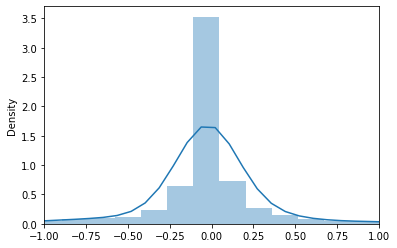

In [12]:
best_xgb.fit(X_train,y_train)
pred=best_xgb.predict(X_test)
sns.distplot(y_test-pred,bins=100)
plt.xlim([-1,1])
MAE=mean_absolute_error(y_test,pred)
print('MAE:',MAE)

/Users/shailmirpuri/opt/anaconda3/envs/vgsales_predict/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


MAE: 0.258015611482614


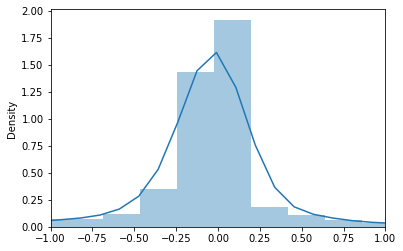

In [14]:
best_rf.fit(X_train,y_train)
pred=best_rf.predict(X_test)
sns.distplot(y_test-pred,bins=100)
plt.xlim([-1,1])
MAE=mean_absolute_error(y_test,pred)
print('MAE:',MAE)

We can see from the distribution plot and mean absolute error metrics that both our Random Forest (RF) and XGBoost Model (XGB) perform similarly in their predictions of our test dataset. Since the RF model is significantly larger in file size and memory used, we will deploy the XGBoost model as our final model.

In [ ]:
# We will compress the XGB model into a smaller file by using the pickle library
import pickle
file1=open('xgboost_model.pkl','wb')
pickle.dump(best_xgb,file1)